# Custom segmentation

The Sopa CLI and pipeline are based on [Cellpose](https://github.com/MouseLand/cellpose) for staining-based segmentation. Yet, if desired, one can implement another staining-based segmentation algorithm.

You can plug your segmentation model into Sopa to benefit from all the other functionalities. In particular, it will scale the segmentation since Sopa will run on small patches.

In [1]:
import sopa

In [2]:
sdata = sopa.io.toy_dataset()

[INFO] (sopa.utils.data) Image of size ((4, 2048, 2048)) with 400 cells and 100 transcripts per cell


## Define your segmentation function

You need a Python function as described below:

- The function input is an image of shape `(C, Y, X)` (`C` is the number of desired channels; it can be one if you want DAPI only)

- The function output is a mask of shape `(Y, X)`. This mask should contain positive values representing the segmented cells, and contain `0` outside of the cells. For instance, if 4 cells are segmented, the mask **should** contain the values 1, 2, 3, and eventually 0 (where there is no cell).

Here is a dummy example of how it could look like:

In [3]:
import numpy as np

def segmentation_function(image: np.ndarray) -> np.ndarray:
    """A dummy example of a custom segmentation method
    that creates one cell (with a padding of 10 pixels).

    Args:
        image: An image of shape `(C, Y, X)`

    Returns:
        A mask of shape `(Y, X)` containing one cell
    """
    mask = np.zeros(image.shape[1:], dtype=int)

    # one cell, corresponding to value 1
    mask[10:100, 10:100] = 1  # squared shaped

    return mask

### Use it via the API

The easiest way to use it is via the API. The process is very similar to Cellpose:

In [4]:
sopa.make_image_patches(sdata, patch_width=1000) # we create 9 patches for the demo

[INFO] (sopa.patches._patches) 9 patches were added to sdata['image_patches']


In [5]:
sopa.segmentation.custom_staining_based(sdata, segmentation_function, channels=["DAPI"])

[WARNING] (sopa._settings) Running without parallelization backend can be slow. Consider using a backend, e.g. via `sopa.settings.parallelization_backend = 'dask'`, or `export SOPA_PARALLELIZATION_BACKEND=dask`.
100%|██████████| 9/9 [00:00<00:00, 25.21it/s]
[INFO] (sopa.segmentation._stainings) Found 9 total cells
Resolving conflicts: 0it [00:00, ?it/s]
[INFO] (sopa.segmentation._stainings) Added 9 cell boundaries in sdata['custom_boundaries']


Now, we have shapes called `"custom_boundaries"` in our SpatialData object:

In [6]:
sdata

SpatialData object
├── Images
│     ├── 'he_image': DataTree[cyx] (3, 1024, 1024), (3, 512, 512), (3, 256, 256)
│     └── 'image': DataArray[cyx] (4, 2048, 2048)
├── Points
│     ├── 'misc': DataFrame with shape: (<Delayed>, 2) (2D points)
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 5) (2D points)
└── Shapes
      ├── 'cells': GeoDataFrame shape: (400, 1) (2D shapes)
      ├── 'custom_boundaries': GeoDataFrame shape: (9, 1) (2D shapes)
      └── 'image_patches': GeoDataFrame shape: (9, 3) (2D shapes)
with coordinate systems:
    ▸ 'global', with elements:
        he_image (Images), image (Images), misc (Points), transcripts (Points), cells (Shapes), custom_boundaries (Shapes), image_patches (Shapes)
    ▸ 'microns', with elements:
        transcripts (Points)

We can continue the normal API process, i.e. using the aggregation:

In [7]:
sopa.aggregate(sdata)

[INFO] (sopa.aggregation.transcripts) Aggregating transcripts over 9 cells


[                                        ] | 0% Completed | 101.21 us

/Users/quentinblampey/mambaforge/envs/sopa/lib/python3.10/site-packages/anndata/_core/storage.py:48: FutureWarning: AnnData previously had undefined behavior around matrices of type <class 'scipy.sparse._coo.coo_matrix'>.In 0.12, passing in this type will throw an error. Please convert to a supported type.Continue using for this minor version at your own risk.
  warnings.warn(msg, FutureWarning)


[########################################] | 100% Completed | 105.11 ms


[INFO] (sopa.aggregation.channels) Aggregating channels intensity over 9 cells with mode='average'


[########################################] | 100% Completed | 101.58 ms


[INFO] (sopa.aggregation.aggregation) Filtering 0 cells
/Users/quentinblampey/dev/_external/spatialdata/src/spatialdata/_core/_elements.py:96: UserWarning: Key `custom_boundaries` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/Users/quentinblampey/dev/sopa/sopa/aggregation/aggregation.py:195: ImplicitModificationWarning: Setting element `.obsm['intensities']` of view, initializing view as actual.
  self.table.obsm[SopaKeys.INTENSITIES_OBSM] = pd.DataFrame(
/Users/quentinblampey/dev/_external/spatialdata/src/spatialdata/_core/_elements.py:96: UserWarning: Key `custom_boundaries` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


For the sake of this tutorial, we show the resulting "dummy" segmentation. As we created one square cell for ech patch, this results in 9 cells:

In [8]:
import spatialdata_plot

INFO     Rasterizing image for faster rendering.                                                                   


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.9530949634755863].


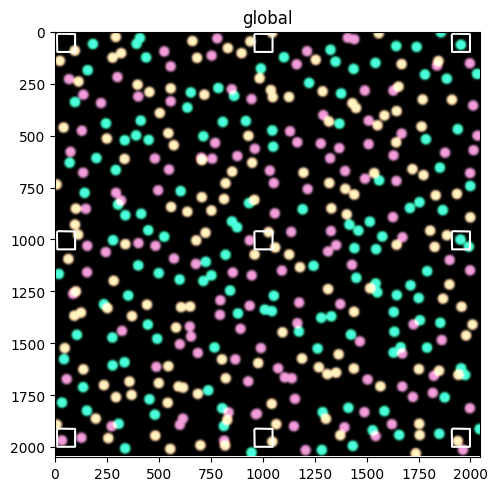

In [10]:
sdata\
    .pl.render_images("image") \
    .pl.render_shapes("custom_boundaries", fill_alpha=0, outline_alpha=1, outline_color="#fff") \
    .pl.show("global")